In [1]:
import numpy as np
import os
import h5py
import skimage.registration as skireg #used for image 
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import fourier_shift
from PIL import Image
import scipy.interpolate as interpolate

In [12]:
image_address = r"D:\globus slate shared data Tankam Lab\IR_card_glass_side_3_13_2025\scan1"
image_address2 = r"D:\globus slate shared data Tankam Lab\IR_card_glass_side_3_13_2025\scan6"
with h5py.File(os.path.join(image_address, f'{os.path.basename(image_address)}.h5'), "r") as h5f:
    h5_data = h5f["volume"]
    h5_slice = h5_data[:, 263, :]
    temp_slice = np.array(h5_slice)
    norm = cv2.normalize(temp_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint16)
    norm = cv2.convertScaleAbs(norm, 1.2, 2)

with h5py.File(os.path.join(image_address2, f'{os.path.basename(image_address2)}.h5'), "r") as h5f:
    h5_data = h5f["volume"]
    h5_slice = h5_data[:, 263, :]
    temp_slice = np.array(h5_slice)
    norm2 = cv2.normalize(temp_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint16)
    norm2 = cv2.convertScaleAbs(norm2, 1.2, 2)

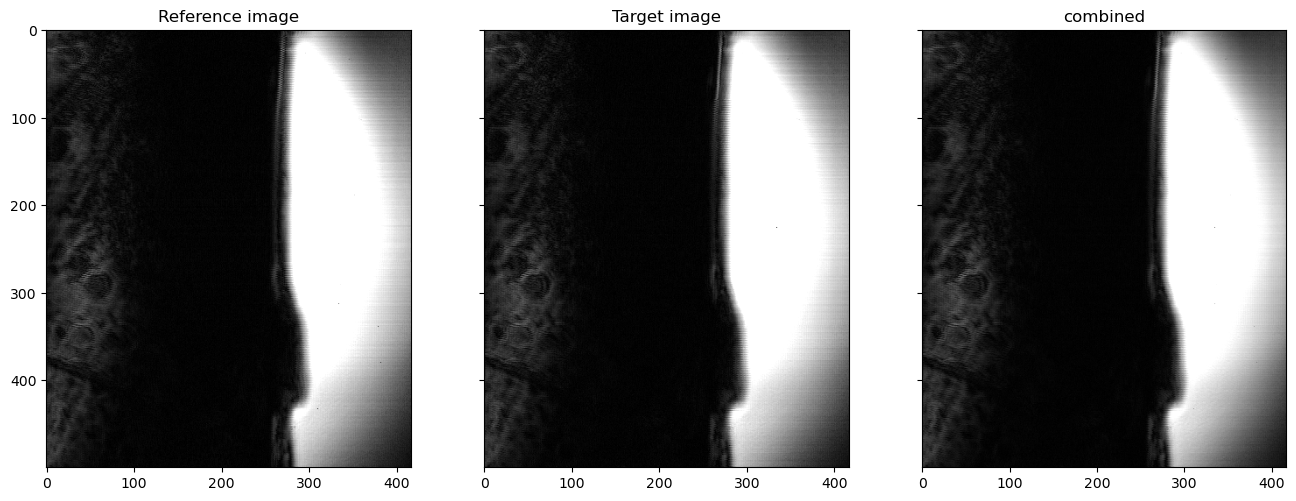

In [13]:
# norm2[300:304, :] = 255
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (16, 8))
ax1.imshow(norm, cmap="gray")
# ax1.set_axis_off()
ax1.set_title("Reference image")

ax2.imshow(norm2, cmap="gray")
# ax2.set_axis_off()
ax2.set_title("Target image")

ax3.imshow(norm, cmap="gray")
ax3.imshow(norm2, cmap="gray", alpha=0.6)
ax3.set_title("combined")
plt.show()

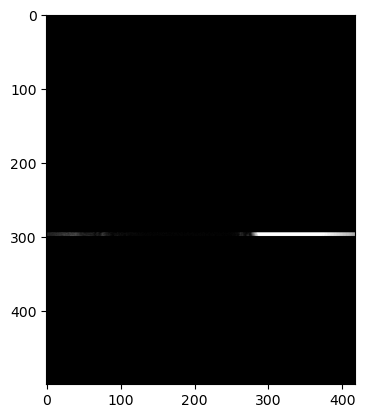

In [14]:
#testing the POC method and it's effectiveness
strip = norm2[295:300, :].copy()
zero_padd = np.full(norm.shape, 0)
zero_padd[295:300, :] = strip
plt.imshow(zero_padd, cmap="gray")

Detected subpixel shift: [ 138. -107.]


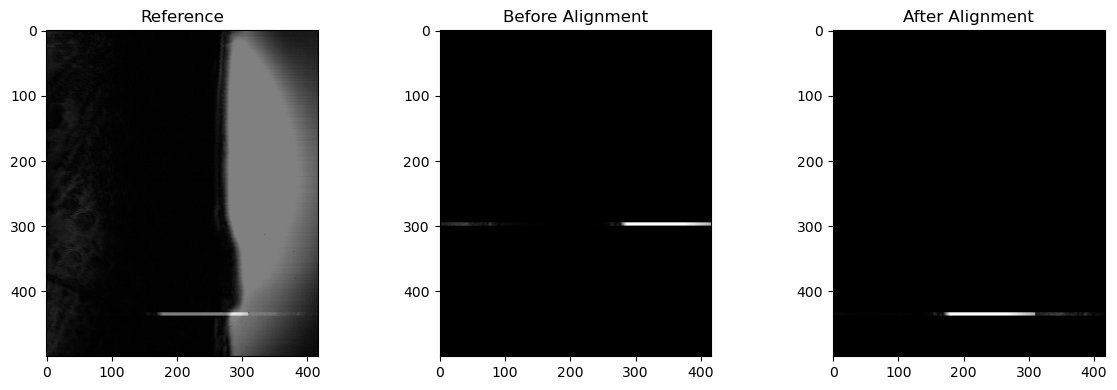

In [15]:
# compute the shift
shift, error, diffphase = skireg.phase_cross_correlation(norm, zero_padd)
shifted_fft = fourier_shift(np.fft.fftn(zero_padd), shift)
aligned_image = np.fft.ifftn(shifted_fft).real
print(f"Detected subpixel shift: {shift}")


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(norm, cmap='gray')
ax[0].imshow(aligned_image, cmap = "gray", alpha = 0.5)
ax[0].set_title('Reference')
ax[1].imshow(zero_padd, cmap='gray')
ax[1].set_title('Before Alignment')
ax[2].imshow(aligned_image, cmap='gray')
ax[2].set_title('After Alignment')
plt.tight_layout()
plt.show()

In [10]:
np.uint16(shift[0])

np.uint16(0)

In [16]:
image = []
np_image_array = np.zeros((30, norm.shape[0], norm.shape[1]))#store image
for j in range(30):
    image_address2 = os.path.join(r"D:\globus slate shared data Tankam Lab\IR_card_glass_side_3_13_2025", f'scan{j + 1}')
    with h5py.File(os.path.join(image_address2, f'{os.path.basename(image_address2)}.h5'), "r") as h5f:
        h5_data = h5f["volume"]
        h5_slice = h5_data[:, 263, :]
        temp_slice = np.array(h5_slice)
        norm2 = cv2.normalize(temp_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint16)
        norm2 = cv2.convertScaleAbs(norm2, 1.2, 2)
    correct_frame = np.full(norm.shape, np.nan)#used to store corrected en-face image
    index_list = list(range(0, norm.shape[0], 5))
    for i in range(len(index_list) - 1):
        strip = norm2[index_list[i]:index_list[i + 1], :].copy()
        zero_padd = np.full(norm.shape, 0)
        zero_padd[index_list[i]:index_list[i + 1], :] = strip
        shift, error, diffphase = skireg.phase_cross_correlation(norm, zero_padd)
        y_shift = np.uint(shift[0])
        if index_list[i] + shift[0] < 0 or index_list[i + 1] + shift[0] > norm.shape[0]:
            correct_frame[index_list[i]:index_list[i + 1], :] = norm[index_list[i]:index_list[i + 1], :]
        elif y_shift <= 10:
            y_shift = np.uint(shift[0])
            correct_frame[(index_list[i] + y_shift) : (index_list[i + 1] + y_shift), :] = strip

    # image.append(Image.fromarray(correct_frame.astype(np.uint8)))
    np_image_array[j, :, :] = correct_frame


    

In [17]:
#interpolate all nan value in the dataset
gridx, gridy, gridz = np.mgrid[0:30, 0:norm.shape[0], 0:norm.shape[1]]
frame_not_nan = np.argwhere(~np.isnan(np_image_array))#coordinate of all real value
grid_inter = interpolate.griddata((frame_not_nan[:, 0], frame_not_nan[:, 1], frame_not_nan[:, 2]), np_image_array[frame_not_nan[:, 0], frame_not_nan[:, 1], frame_not_nan[:, 2]], (gridx, gridy, gridz), method="nearest")
# image[0].save(os.path.join(address, "corrected_img.gif"), save_all = True, append_images=image[1:], optimize=False, duration=1, loop=0)

In [19]:
#generate gif images
gif_address = r"D:\globus slate shared data Tankam Lab\IR_card_glass_side_3_13_2025"
for j in range(30):
    gif_frame = grid_inter[j, :, :]
    image.append(Image.fromarray(gif_frame.astype(np.uint8)))
image[0].save(os.path.join(gif_address, "corrected_img.gif"), save_all = True, append_images=image[1:], optimize=False, duration=1, loop=0)

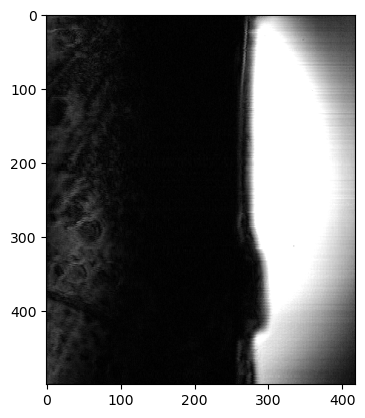

In [18]:
# mean_image = np.max(image, axis=0)
plt.imshow(grid_inter[15, :, :], cmap="gray")